# Replicating Cross-Repo Paper

Unorganized Notes
- Main Dataset https://www.kaggle.com/datasets/johntukey/github-dataset
- Cross-Repo Paper https://ieeexplore.ieee.org/document/8947641

1. Import modules

In [1]:
from datetime import datetime, timedelta, timezone
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

2. Load JSON dataset

In [2]:
# paste file directory below
path = "dataset.json"

df = pd.read_json( path, lines = True )

3. Add commit list to repos

In [3]:
# function to create a list of repos with their commits
def addCommitListToRepos(df):

    # main dataset only keeps username, user id, number of commits, and commit list
    df = df[ [ "login", "id", "commits", "commit_list" ] ]

    # copy of the dataset used only for iterating through each user's commit lists
    commitLists = df.copy()

    # only keep commit list
    commitLists = commitLists[ "commit_list" ]

    # add commits to repos
    reposWithCommits = {}
    for currList in commitLists:
        for commit in currList:
            if commit[ "repo_id" ] not in reposWithCommits:
                reposWithCommits[ commit[ "repo_id" ] ] = []
            reposWithCommits[ commit[ "repo_id" ] ].append( commit )

    # return repos with commits for further use in this notebook
    return reposWithCommits

In [4]:
def printReposWithCommits(reposWithCommits, max_repos=5, max_commits_per_repo=10):
    # Create a shallow copy of the dictionary to avoid mutating the original data
    limitedReposWithCommits = dict(list(reposWithCommits.items())[:max_repos])
    
    # Limit the number of commits per repository
    for repo_id, commits in limitedReposWithCommits.items():
        limitedReposWithCommits[repo_id] = commits[:max_commits_per_repo]

    # Convert the limited dictionary to a JSON string with indentation for readability
    reposWithCommitsJson = json.dumps(limitedReposWithCommits, indent=4)
    print(reposWithCommitsJson)

4. Initialize a dictionary with keys of repo IDs and values of a list of commits to that repo

In [5]:
reposWithCommits = addCommitListToRepos(df)

# Call the function with your data, specifying how many repos and commits per repo to print
printReposWithCommits(reposWithCommits, max_repos=5, max_commits_per_repo=10)

{
    "98311519": [
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:56:08.000-03:00",
            "committer_id": 30438508,
            "message": "Set theme jekyll-theme-merlot",
            "repo_description": null,
            "generate_at": "2017-07-25 10:56:08.000-03:00",
            "author_id": 30438508,
            "repo_name": "MelLobo/Fonte"
        },
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:52:25.000-03:00",
            "committer_id": 19864447,
            "message": "Create README.md",
            "repo_description": null,
            "generate_at": "2017-07-25 10:52:25.000-03:00",
            "author_id": 30438508,
            "repo_name": "MelLobo/Fonte"
        },
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:54:36.000-03:00",
            "co

5. Test for proper intialization of reposWithCommits

In [ ]:
# Assuming reposWithCommits is a dictionary where keys are repo IDs and values are lists of commits

# Calculate the total number of repos
total_repos = len(reposWithCommits.keys())

# Calculate the total number of commits
numCommits = sum(len(commitList) for commitList in reposWithCommits.values())

# Data for specific repo IDs
repo_ids = [121300003, 88377551, 131508193, 132465788, 132464776]
repos_data = {repo_id: reposWithCommits[repo_id] for repo_id in repo_ids if repo_id in reposWithCommits}

# Structuring the data
data_to_print = {
    "Total number of repos": total_repos,
    "Total number of commits": numCommits,
    "repos": repos_data
}

# Pretty printing the data as JSON
print(json.dumps(data_to_print, indent=4))

6. Manually create two features:
    * Number of commits: commit count for a repository
    * Commit List: commit objects including commit timestamp & relevant features

In [ ]:
# Flatten the structure into a list of dictionaries for DataFrame creation
commit_details = []
for repo_id, commits in reposWithCommits.items():
    for commit in commits:
        commit_details.append(commit)

# Create the initial DataFrame
df_commits = pd.DataFrame(commit_details)

In [ ]:
# Group by 'repo_id' to aggregate commits
repo_summary = df_commits.groupby('repo_id').agg({
    'repo_owner_id': 'first',  # Assuming repo_owner_id is constant per repo
    'repo_description': 'first',  # Assuming repo_description is constant per repo
    'repo_name': 'first',  # Assuming repo_name is constant per repo
    'commit_at': lambda x: list(x),
    'committer_id': lambda x: list(x),
    'message': lambda x: list(x),
    'generate_at': lambda x: list(x),
    'author_id': lambda x: list(x)
}).reset_index()

# Create the 'commit_list' column by combining columns into dictionaries
repo_summary['commit_list'] = repo_summary.apply(lambda row: [
    {
        'commit_at': commit_at,
        'committer_id': committer_id,
        'message': message,
        'generate_at': generate_at,
        'author_id': author_id
    }
    for commit_at, committer_id, message, generate_at, author_id in zip(
        row['commit_at'], row['committer_id'], row['message'], row['generate_at'], row['author_id']
    )
], axis=1)

# Calculate 'commit_count' for each repository
repo_summary['commit_count'] = repo_summary['commit_list'].apply(len)

# Drop individual commit columns as they are now aggregated into 'commit_list'
repo_summary.drop(columns=['commit_at', 'committer_id', 'message', 'generate_at', 'author_id'], inplace=True)


In [ ]:
repo_summary.head()

7. EDA - Exploratory Data Analysis

In [ ]:
# Distribution of commits per user
sns.histplot(df['commits'], kde=True)
plt.title('Distribution of Commits per User')
plt.xlabel('Number of Commits')
plt.yscale('log')
plt.ylabel('Frequency')
plt.show()

# Aggregate statistics for commits
print(df['commits'].describe())

In [ ]:
# Sort the DataFrame by 'commit_count' in descending order
repo_summary_sorted = repo_summary.sort_values(by='commit_count', ascending=False)

# Display the sorted DataFrame
print(repo_summary_sorted)

8. Top 100 Repos by Commit Count

In [ ]:
# Sort the DataFrame by 'commit_count' in descending order and select the top 100
top_100_repos = repo_summary.sort_values(by='commit_count', ascending=False).head(100)

# Display the DataFrame with the top 100 repositories
print(top_100_repos)

In [ ]:
# Convert the DataFrame into a CSV file
repo_summary.to_csv('commits.csv', index=False)

In [ ]:
# Open commit-centric and repo-centric dataframes to be joined together
df_commits = pd.read_csv('commits.csv')
df_repos = pd.read_csv('dataset.csv')

In [ ]:
df_commits.head()

In [ ]:
df_repos.head()

In [ ]:
# Perform a left join with df_repos on the left
df_merged = pd.merge(df_repos, df_commits, left_on='repo_full_name', right_on='repo_name', how='left', suffixes=('', '_drop'))

# Drop duplicate or unwanted columns post-merge, especially those with '_drop' suffix
df_merged = df_merged[[c for c in df_merged.columns if not c.endswith('_drop')]]

# For repositories without attached commits, set 'commits' to 0 and 'commit_list' to []
# Assuming 'commits' is a column you're interested in; replace or add as necessary based on your actual data structure
df_merged['commit_count'] = df_merged['commit_count'].fillna(0)
df_merged['commit_list'] = df_merged.apply(lambda row: [] if pd.isnull(row['commit_count']) else row['commit_list'], axis=1)

# Display the first few rows of the merged DataFrame to verify the result
df_merged.head()

In [ ]:
# Display the number of rows and columns in df_merged
num_rows, num_columns = df_merged.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

9. Remove unneccessary columns, impute NaN values to [] or 0.

In [ ]:
# Correcting the drop columns syntax
df_merged.drop(['repo_id', 'repo_owner_id', 'repo_name'], axis=1, inplace=True)

# Imputing missing commit values
df_merged['commit_count'] = df_merged['commit_count'].fillna(0)

# Placeholder for 'commit_list'; assuming you need to create or update it
df_merged['commit_list'] = df_merged.apply(lambda row: [] if row['commit_count'] == 0 else row['commit_list'], axis=1)

In [ ]:
# Display the first few rows of the merged DataFrame to verify the result
print(df_merged.head())

10. Save File to CSV (repos , commit counts , commit_list)

In [ ]:
df_merged.to_csv('repos_commits.csv', index=False)

11. Observe highly-committed repo's and their characteristics shared, if any

In [ ]:
df_sorted_by_commits = df_merged.sort_values(by='commit_count', ascending=False)

In [ ]:
df_sorted_by_commits.head()

In [ ]:
columns_of_interest = ['repo_age', 'repo_stargazers_count', 'repo_forks_count', 'repo_open_issues', 'commit_count']
df_sorted_by_commits[columns_of_interest].describe()

11. Most Active Repositories by 10-day Interval

In [ ]:
df_merged.head()

12. Calculate time between each commit for every repo

In [6]:
def timeBetweenCommits( reposWithCommits ):

    timeBetweenList =[]
    currTimeBetweenList = []
    currTimeList = []
    avgTimeList = []
    medianTimeList = []

    # iterate through all commits lists in reposWithCommits
    for currCommitList in reposWithCommits.values():
        # ignore repos with only 1 or 0 commits
        if len( currCommitList ) <= 1:
            avgTimeList.append( timedelta() )
            medianTimeList.append( timedelta() )
            timeBetweenList.append( [] )
            continue

        # build list of commit timestamps for every repo
        for commit in currCommitList:
            currTimeList.append( commit[ "commit_at" ] )

        # iterate through all commit timestamps for a repo
        for i in range( len(currTimeList) ):
            currTimeZone = currTimeList[i][-1]
            currTimestamp = datetime.fromisoformat( currTimeList[i][:19] )

            # convert all timestamps to UTC based on their time zone
            if currTimeZone == 'Z':
                 # Z represents no offset meaning commited in UTC time zone
                 currTimestamp = currTimestamp.replace( tzinfo = timezone.utc )
            else:
                # get offset from the last 6 characters in the timestamp
                currTimeZone = currTimeList[i][-6:]

                # parse the offset
                h, m = map( int, currTimeZone.split(":") )
                if h < 0:
                    m *= -1
                currTimeZone = timedelta( hours = h, minutes = m )
                currTimeZone = timezone( currTimeZone )
                currTimestamp = currTimestamp.replace( tzinfo = currTimeZone ).astimezone( timezone.utc )

            currTimeList[i] = currTimestamp

        # sort commit timestamps in ascending order
        currTimeList = sorted( currTimeList )

        # calculate time between each commit
        currAvgTime = timedelta()
        for i in range( len(currTimeList) - 1 ):
            currTimeBetweenList.append( currTimeList[i + 1] - currTimeList[i] )
            currAvgTime = currAvgTime + ( currTimeList[i + 1] - currTimeList[i] )

        # calculate average time and append to average time list
        currAvgTime = currAvgTime / ( len( currCommitList ) - 1 )
        medianTimeList.append( statistics.median(currTimeBetweenList) )
        avgTimeList.append( currAvgTime )
        timeBetweenList.append( currTimeBetweenList )
        currTimeList = []
        currTimeBetweenList = []

    # represent reposWithCommits as Pandas DataFrame
    data = { "repo_id": reposWithCommits.keys(),
             "avg_time_between_commits": avgTimeList,
             "median_time_between_commits": medianTimeList }
    data = pd.DataFrame.from_dict( data )

    return data

13. Initialize Pandas DataFrame of time between commits for every repo

In [7]:
repoTimeBetweenCommits = timeBetweenCommits( reposWithCommits )

14. Test for proper initialization of avgTimeBetweenCommits

In [8]:
# Output format of locally stored dataset
#           repo_id avg_time_between_commits median_time_between_commits
# 0        98311519   0 days 00:01:51.500000      0 days 00:01:51.500000
# 1       134804722          0 days 00:00:00             0 days 00:00:00
# 2       134804877          0 days 00:00:00             0 days 00:00:00
# 3       134804933          0 days 00:00:00             0 days 00:00:00
# 4        62891737          0 days 00:00:00             0 days 00:00:00
# ...           ...                      ...                         ...
# 447106   29204775   3 days 07:44:25.241379             0 days 00:25:41
# 447107   60782700   0 days 00:23:15.555556             0 days 00:08:38
# 447108   55134604   1 days 13:25:59.135135             0 days 00:16:37
# 447109   96882560   9 days 07:47:14.730769             0 days 00:48:55
# 447110   74912660   1 days 11:31:33.979592             0 days 00:35:57

# [447111 rows x 2 columns]

print( repoTimeBetweenCommits )

          repo_id avg_time_between_commits median_time_between_commits
0        98311519   0 days 00:01:51.500000      0 days 00:01:51.500000
1       134804722          0 days 00:00:00             0 days 00:00:00
2       134804877          0 days 00:00:00             0 days 00:00:00
3       134804933          0 days 00:00:00             0 days 00:00:00
4        62891737          0 days 00:00:00             0 days 00:00:00
...           ...                      ...                         ...
447106   29204775   3 days 07:44:25.241379             0 days 00:25:41
447107   60782700   0 days 00:23:15.555556             0 days 00:08:38
447108   55134604   1 days 13:25:59.135135             0 days 00:16:37
447109   96882560   9 days 07:47:14.730769             0 days 00:48:55
447110   74912660   1 days 11:31:33.979592             0 days 00:35:57

[447111 rows x 3 columns]


15. Plot difference between average and median of time between commits for every repo

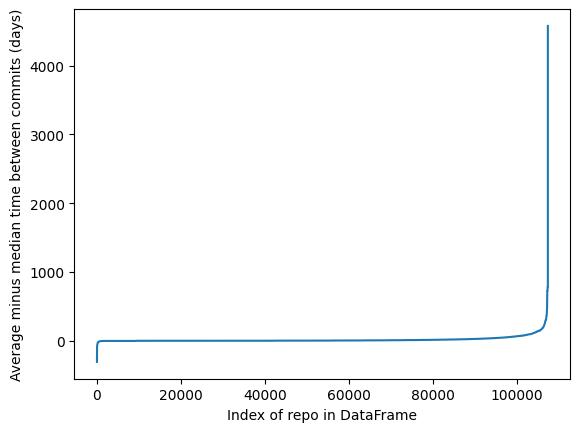

In [40]:
def plotTimeBetweenCommits( repoTimeBetweenCommits ):

    ypoints = [ td.days for td in ( repoTimeBetweenCommits["avg_time_between_commits"] - repoTimeBetweenCommits["median_time_between_commits"] ) if td.days != 0 ]
    xpoints = [ i for i in range( len(ypoints) ) ]

    ypoints = sorted( ypoints )

    plt.xlabel( "Index of repo in DataFrame" )
    plt.ylabel( "Average minus median time between commits (days)" )

    plt.plot(xpoints, ypoints)
    plt.show()

plotTimeBetweenCommits( repoTimeBetweenCommits )